In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("کتابخانه‌ها با موفقیت بارگذاری شدند.")

df = pd.read_csv("imdbMovies1.csv")
df.head()  # To-Do

کتابخانه‌ها با موفقیت بارگذاری شدند.


,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,1,3,4.0,Grumpier Old Men (1995)
2,1,6,4.0,Heat (1995)
3,1,47,5.0,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,"Usual Suspects, The (1995)"


In [2]:
df.shape

(100776, 4)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100776 entries, 0 to 100775
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100776 non-null  int64  
 1   movieId  100776 non-null  int64  
 2   rating   100776 non-null  float64
 3   title    100776 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 3.1+ MB


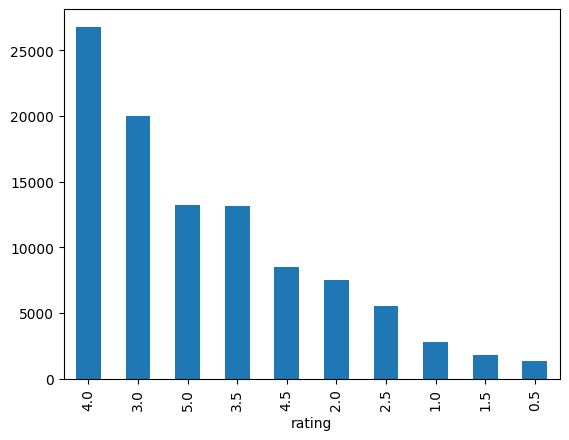

In [ ]:
## با اجرای این کد توزیع فراوانی امتیازات داده شده به فیلم ها را میتوانید مشاهده کنید.
df["rating"].value_counts().plot(kind="bar")
plt.show()

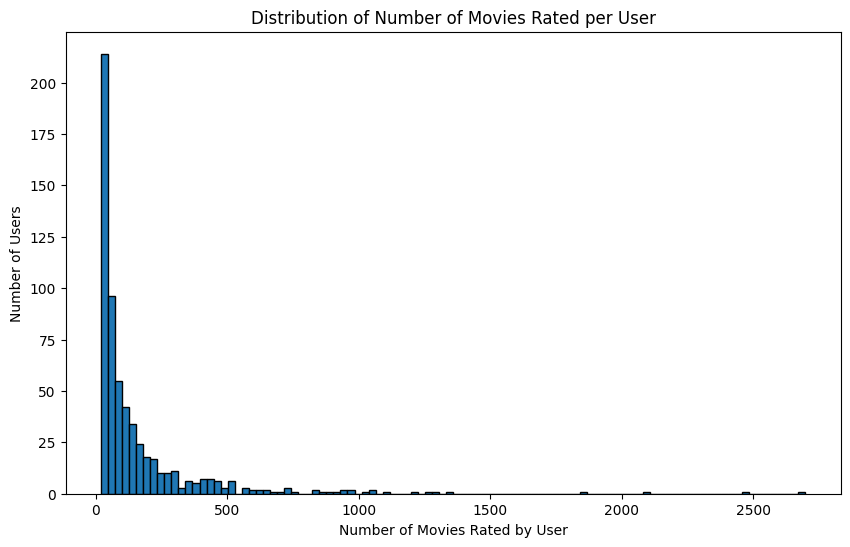

In [ ]:
user_rating_counts = df["userId"].value_counts()
plt.figure(figsize=(10, 6))
user_rating_counts.plot(kind="hist", bins=100, edgecolor="black")
plt.xlabel("Number of Movies Rated by User")
plt.ylabel("Number of Users")
plt.title("Distribution of Number of Movies Rated per User")
plt.show()

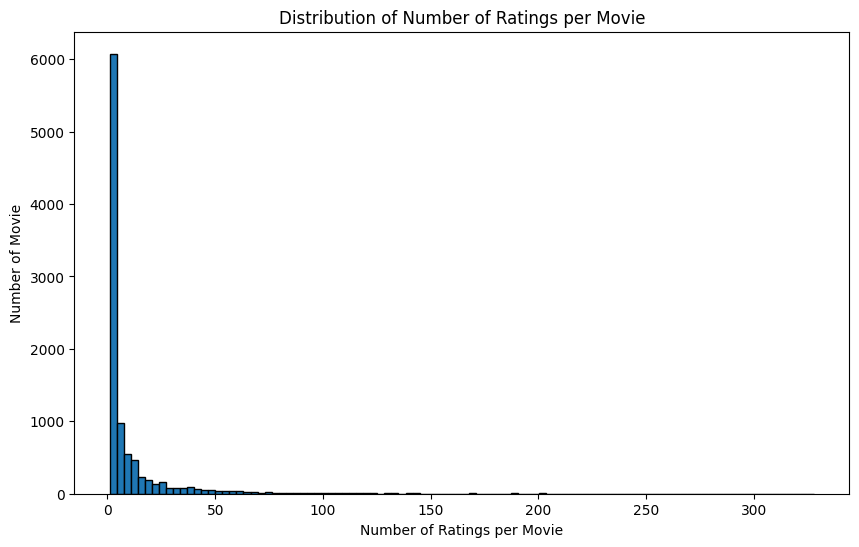

In [ ]:
book_rating_counts = df["movieId"].value_counts()
plt.figure(figsize=(10, 6))
book_rating_counts.plot(kind="hist", bins=100, edgecolor="black")
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Number of Movie")
plt.title("Distribution of Number of Ratings per Movie")
plt.show()

In [ ]:
user_counts = df["userId"].value_counts()
# محاسبه تعداد امتیازات برای هر کتاب
book_counts = df["movieId"].value_counts()

# تعیین آستانه (Threshold)
# فقط کاربرانی که حداقل به 5 کتاب امتیاز داده‌اند
# و کتاب‌هایی که حداقل 10 امتیاز دریافت کرده‌اند را نگه می‌داریم
min_user_ratings = 5
min_book_ratings = 10

# فیلتر کردن کاربران و کتاب‌ها
qualified_users = user_counts[user_counts >= min_user_ratings].index
qualified_books = book_counts[book_counts >= min_book_ratings].index

# فیلتر کردن DataFrame اصلی
df_filtered = df[
    df["userId"].isin(qualified_users) & df["movieId"].isin(qualified_books)
]

print(f"\nتعداد رکوردهای اولیه: {len(df)}")
print(f"تعداد رکوردهای پس از فیلتر کردن: {len(df_filtered)}")
print("شکل نهایی داده‌ها برای مدل‌سازی:", df_filtered.shape)


تعداد رکوردهای اولیه: 100776
تعداد رکوردهای پس از فیلتر کردن: 81058
شکل نهایی داده‌ها برای مدل‌سازی: (81058, 4)


In [ ]:
# حذف کاربرانی که فقط یک امتیاز دارند (برای جلوگیری از خطای stratify)
user_counts = df_filtered["userId"].value_counts()
users_with_enough_ratings = user_counts[user_counts > 1].index
df_filtered_strat = df_filtered[df_filtered["userId"].isin(users_with_enough_ratings)]

# تقسیم داده‌ها به نسبت 80% آموزشی و 20% آزمایشی
train_data, test_data = train_test_split(
    df_filtered_strat,
    test_size=0.2,
    random_state=42,
    stratify=df_filtered_strat["userId"],
)

print(f"\nتعداد رکوردهای مجموعه آموزشی: {len(train_data)}")
print(f"تعداد رکوردهای مجموعه آزمایشی: {len(test_data)}")


تعداد رکوردهای مجموعه آموزشی: 64846
تعداد رکوردهای مجموعه آزمایشی: 16212


In [ ]:
# ساخت ماتریس کاربر-کتاب با استفاده از داده‌های آموزشی
user_item_matrix = train_data.pivot_table(
    index="userId", columns="movieId", values="rating"
)

# پر کردن مقادیر NaN با 0 (به این معنی که کاربر به آن کتاب امتیاز نداده است)
user_item_matrix.fillna(0, inplace=True)

print("\nماتریس کاربر-کتاب با موفقیت ساخته شد.")
print("شکل ماتریس:", user_item_matrix.shape)


ماتریس کاربر-کتاب با موفقیت ساخته شد.
شکل ماتریس: (610, 2268)


In [ ]:
user_item_matrix.head(10)

In [ ]:
item_similarity = cosine_similarity(user_item_matrix.T)

# تبدیل نتیجه به یک DataFrame برای خوانایی بهتر
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=user_item_matrix.columns,  # اندیس‌ها شناسه فیلم‌ها هستند
    columns=user_item_matrix.columns,  # ستون‌ها نیز شناسه فیلم‌ها هستند
)


print("\nماتریس شباهت کاربر-کاربر با موفقیت محاسبه شد.")
print("شکل ماتریس شباهت:", item_similarity_df.shape)
print("نمونه‌ای از ماتریس شباهت:")
item_similarity_df.head()


ماتریس شباهت کاربر-کاربر با موفقیت محاسبه شد.
شکل ماتریس شباهت: (2268, 2268)
نمونه‌ای از ماتریس شباهت:


movieId,1,2,3,5,6,7,9,10,11,12,...,166461,166528,166643,168250,168252,174055,176371,177765,179819,187593
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.338911,0.269031,0.286684,0.295635,0.235304,0.246737,0.344924,0.266736,0.210676,...,0.049396,0.175221,0.135178,0.094350,0.141164,0.052527,0.115972,0.054457,0.106520,0.113692
2,0.338911,1.000000,0.251235,0.248366,0.270153,0.131347,0.066207,0.320026,0.226166,0.102245,...,0.100917,0.139106,0.073133,0.018878,0.177479,0.086446,0.164201,0.043939,0.101666,0.069625
3,0.269031,0.251235,1.000000,0.421687,0.251132,0.269850,0.177978,0.179445,0.220800,0.213981,...,0.000000,0.073403,0.070641,0.017778,0.070855,0.093578,0.106223,0.000000,0.077632,0.000000
5,0.286684,0.248366,0.421687,1.000000,0.261860,0.342638,0.176986,0.219120,0.285868,0.237446,...,0.000000,0.043525,0.036343,0.000000,0.039881,0.048144,0.057615,0.000000,0.039940,0.000000
6,0.295635,0.270153,0.251132,0.261860,1.000000,0.169783,0.111227,0.276442,0.206629,0.142551,...,0.000000,0.167904,0.077780,0.044743,0.131835,0.044158,0.176148,0.000000,0.086156,0.073195


In [ ]:
def predict_rating_ibcf(user_id, movie_id, user_item_matrix, item_similarity_df, k=10):
    # بررسی اولیه برای وجود کاربر و فیلم
    if (
        movie_id not in item_similarity_df.index
        or user_id not in user_item_matrix.index
    ):
        return 2.5  # بازگرداندن امتیاز میانگین به عنوان پیش‌فرض

    # 1. پیدا کردن فیلم‌هایی که کاربر به آن‌ها امتیاز داده است
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0]

    # اگر کاربر به هیچ فیلمی امتیاز نداده باشد
    if rated_movies.empty:
        return 2.5

    # 2. پیدا کردن شباهت فیلم هدف با تمام فیلم‌هایی که کاربر امتیاز داده
    similarities_to_rated_movies = item_similarity_df.loc[movie_id, rated_movies.index]

    # 3. انتخاب k فیلم مشابه برتر از میان فیلم‌های امتیاز داده شده
    top_k_similar_items = similarities_to_rated_movies.nlargest(k)

    # اگر هیچ آیتم مشابهی در تاریخچه کاربر نباشد
    if top_k_similar_items.empty:
        return 2.5

    # 4. محاسبه میانگین وزنی
    # وزن‌ها همان امتیازات شباهت هستند
    numerator = 0
    denominator = 0
    for sim_movie_id, similarity_score in top_k_similar_items.items():
        user_rating_for_sim_movie = rated_movies.loc[sim_movie_id]
        numerator += similarity_score * user_rating_for_sim_movie
        denominator += similarity_score

    if denominator == 0:
        return 2.5  # برای جلوگیری از تقسیم بر صفر

    return numerator / denominator

In [ ]:
user = 71
movie = 110  # (first find the movieId)


predicted_score = predict_rating_ibcf(
    user_id=user,
    movie_id=movie,
    user_item_matrix=user_item_matrix,
    item_similarity_df=item_similarity_df,
    k=10,  # می‌توانید این مقدار را تغییر دهید
)

print(
    f"\nامتیاز پیش‌بینی شده برای کاربر {user} و فیلم {movie} برابر است با: {predicted_score:.2f}"
)


امتیاز پیش‌بینی شده برای کاربر 71 و فیلم 110 برابر است با: 3.79


In [ ]:
user = 53
movie = 115713  # (first find the movieId)
predicted_score = predict_rating_ibcf(
    user_id=user,
    movie_id=movie,
    user_item_matrix=user_item_matrix,
    item_similarity_df=item_similarity_df,
    k=10,  # می‌توانید این مقدار را تغییر دهید
)

print(
    f"\nامتیاز پیش‌بینی شده برای کاربر {user} و فیلم {movie} برابر است با: {predicted_score:.2f}"
)


امتیاز پیش‌بینی شده برای کاربر 53 و فیلم 115713 برابر است با: 5.00


In [ ]:
user = 463
movie = ...  # (first find the movieId)

In [ ]:
def evaluate_ibcf_model(test_data, user_item_matrix, item_similarity_df, k=10):
    print(f"\n--- شروع ارزیابی مدل Item-Based CF با k = {k} ---")

    predictions = []
    actuals = []

    # فقط رکوردهایی از مجموعه تست را ارزیابی می‌کنیم که کاربر و فیلم آنها در مجموعه آموزشی حضور دارند
    test_data_eval = test_data[
        test_data["userId"].isin(user_item_matrix.index)
        & test_data["movieId"].isin(user_item_matrix.columns)
    ]

    # --- بخش کلیدی تغییر یافته ---
    for _, row in test_data_eval.iterrows():
        user = row["userId"]
        movie = row["movieId"]
        actual_rating = row["rating"]

        # فراخوانی تابع پیش‌بینی مخصوص IBCF
        predicted_rating = predict_rating_ibcf(
            user_id=user,
            movie_id=movie,
            user_item_matrix=user_item_matrix,
            item_similarity_df=item_similarity_df,  # استفاده از ماتریس شباهت آیتم-آیتم
            k=k,
        )

        predictions.append(predicted_rating)
        actuals.append(actual_rating)

    # محاسبه متریک‌های ارزیابی (این بخش بدون تغییر است)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)

    print("\n--- نتایج ارزیابی مدل IBCF ---")
    print(f"برای k = {k}:")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"MAE (Mean Absolute Error):      {mae:.4f}")

    return rmse, mae

In [ ]:
k_to_test_ibcf = 10

evaluate_ibcf_model(
    test_data=test_data,
    user_item_matrix=user_item_matrix,
    item_similarity_df=item_similarity_df,
    k=k_to_test_ibcf,
)


--- شروع ارزیابی مدل Item-Based CF با k = 10 ---

--- نتایج ارزیابی مدل IBCF ---
برای k = 10:
RMSE (Root Mean Squared Error): 0.8535
MAE (Mean Absolute Error):      0.6465


(0.8534761387423437, 0.6464924690984603)

In [ ]:
print("شکل ماتریس کاربر-آیتم اولیه:", user_item_matrix.shape)

item_user_matrix = user_item_matrix.T

print("\nدر حال محاسبه ماتریس شباهت آیتم-آیتم با همبستگی پیرسون...")
item_similarity_pearson_df = user_item_matrix.corr(method="pearson")

item_similarity_pearson_df.fillna(0, inplace=True)

print("\nمحاسبه با موفقیت انجام شد!")
print("شکل ماتریس شباهت فیلم-فیلم:", item_similarity_pearson_df.shape)
print("\nنمونه‌ای از ماتریس شباهت آیتم-آیتم (پیرسون):")
item_similarity_pearson_df.head()

شکل ماتریس کاربر-آیتم اولیه: (610, 2268)

در حال محاسبه ماتریس شباهت آیتم-آیتم با همبستگی پیرسون...

محاسبه با موفقیت انجام شد!
شکل ماتریس شباهت فیلم-فیلم: (2268, 2268)

نمونه‌ای از ماتریس شباهت آیتم-آیتم (پیرسون):


movieId,1,2,3,5,6,7,9,10,11,12,...,166461,166528,166643,168250,168252,174055,176371,177765,179819,187593
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.179611,0.174307,0.184828,0.145070,0.122663,0.211624,0.169677,0.144199,0.157333,...,-0.007615,0.096257,0.090078,0.035122,0.055852,-0.001712,0.046630,-0.016865,0.058922,0.054776
2,0.179611,1.000000,0.180103,0.170069,0.163212,0.039737,0.019097,0.198621,0.134944,0.050644,...,0.066356,0.078596,0.033734,-0.029553,0.120873,0.052075,0.119457,-0.005380,0.066497,0.023459
3,0.174307,0.180103,1.000000,0.384313,0.186244,0.222726,0.152770,0.093815,0.164771,0.185940,...,-0.026082,0.032092,0.045568,-0.011848,0.029550,0.071642,0.074498,-0.032173,0.053888,-0.031618
5,0.184828,0.170069,0.384313,1.000000,0.192032,0.296651,0.149981,0.130717,0.230126,0.208520,...,-0.028241,-0.002659,0.007931,-0.032798,-0.006353,0.022776,0.021225,-0.034837,0.012865,-0.034236
6,0.145070,0.163212,0.186244,0.192032,1.000000,0.090901,0.071807,0.160967,0.121954,0.098683,...,-0.038724,0.115185,0.042271,0.002992,0.076358,0.009807,0.135922,-0.047767,0.052852,0.031575


In [ ]:
# user = 44
# movie =... #(first find the movieId)

user = 44
movie = 595  # (first find the movieId)
predicted_score = predict_rating_ibcf(
    user_id=user,
    movie_id=movie,
    user_item_matrix=user_item_matrix,
    item_similarity_df=item_similarity_pearson_df,
    k=10,  # می‌توانید این مقدار را تغییر دهید
)

print(
    f"\nامتیاز پیش‌بینی شده برای کاربر {user} و فیلم {movie} برابر است با: {predicted_score:.2f}"
)


امتیاز پیش‌بینی شده برای کاربر 44 و فیلم 595 برابر است با: 3.12


In [ ]:
user = 4
movie = 356  # (first find the movieId)
predicted_score = predict_rating_ibcf(
    user_id=user,
    movie_id=movie,
    user_item_matrix=user_item_matrix,
    item_similarity_df=item_similarity_pearson_df,
    k=10,  # می‌توانید این مقدار را تغییر دهید
)

print(
    f"\nامتیاز پیش‌بینی شده برای کاربر {user} و فیلم {movie} برابر است با: {predicted_score:.2f}"
)


امتیاز پیش‌بینی شده برای کاربر 4 و فیلم 356 برابر است با: 2.61


In [ ]:
import pandas as pd
import numpy as np


def predict_rating_ibcf_with_details(
    user_id, movie_id, user_item_matrix, item_similarity_df, k=10
):
    """
    امتیاز را پیش‌بینی کرده و جزئیات فیلم‌های تاثیرگذار را نیز برمی‌گرداند.
    """
    # بررسی اولیه
    if (
        movie_id not in item_similarity_df.index
        or user_id not in user_item_matrix.index
    ):
        return 2.5, pd.DataFrame()  # برگرداندن امتیاز پیش‌فرض و یک دیتافریم خالی

    # 1. پیدا کردن فیلم‌هایی که کاربر امتیاز داده
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0]

    if rated_movies.empty:
        return 2.5, pd.DataFrame()

    # 2. پیدا کردن اشتراک بین فیلم‌های امتیاز داده شده و فیلم‌های موجود در مدل
    valid_rated_movies_index = rated_movies.index.intersection(
        item_similarity_df.columns
    )

    if valid_rated_movies_index.empty:
        return 2.5, pd.DataFrame()

    # 3. پیدا کردن شباهت فیلم هدف با فیلم‌های معتبر
    similarities_to_rated_movies = item_similarity_df.loc[
        movie_id, valid_rated_movies_index
    ]

    # 4. انتخاب k فیلم مشابه برتر
    top_k_similar_items = similarities_to_rated_movies.nlargest(k)

    if top_k_similar_items.empty:
        return 2.5, pd.DataFrame()

    # 5. محاسبه میانگین وزنی و جمع‌آوری جزئیات
    numerator = 0
    denominator = 0
    contributing_movies_details = []  # لیستی برای ذخیره جزئیات

    for sim_movie_id, similarity_score in top_k_similar_items.items():
        user_rating_for_sim_movie = rated_movies.loc[sim_movie_id]

        # محاسبه امتیاز
        numerator += similarity_score * user_rating_for_sim_movie
        denominator += similarity_score

        # اضافه کردن جزئیات به لیست
        contributing_movies_details.append(
            {
                "NeighborMovieID": sim_movie_id,
                "UserRating": user_rating_for_sim_movie,
                "SimilarityToTarget": similarity_score,
            }
        )

    if denominator == 0:
        return 2.5, pd.DataFrame()

    predicted_score = numerator / denominator

    # تبدیل لیست جزئیات به دیتافریم و مرتب‌سازی بر اساس شباهت
    details_df = pd.DataFrame(contributing_movies_details).sort_values(
        by="SimilarityToTarget", ascending=False
    )

    return predicted_score, details_df


# --- نحوه استفاده جدید ---

# فرض کنید متغیرهای لازم از قبل آماده هستند
user = 4
movie = 356
# user_item_matrix
# item_similarity_pearson_df

# حالا تابع دو مقدار را برمی‌گرداند: امتیاز و دیتافریم جزئیات
predicted_score, contributing_details = predict_rating_ibcf_with_details(
    user_id=user,
    movie_id=movie,
    user_item_matrix=user_item_matrix,
    item_similarity_df=item_similarity_pearson_df,
    k=10,
)

# چاپ امتیاز نهایی
print(
    f"\nامتیاز پیش‌بینی شده برای کاربر {user} و فیلم {movie} برابر است با: {predicted_score:.2f}"
)

# چاپ جزئیات در صورتی که وجود داشته باشد
if not contributing_details.empty:
    print("\nاین پیش‌بینی بر اساس فیلم‌های زیر از تاریخچه کاربر محاسبه شد:")
    # استفاده از to_string() برای نمایش بهتر و کامل دیتافریم
    print(contributing_details.to_string(index=False))
else:
    print("\nهیچ فیلم مشابهی در تاریخچه کاربر برای انجام پیش‌بینی یافت نشد.")


امتیاز پیش‌بینی شده برای کاربر 4 و فیلم 356 برابر است با: 2.61

این پیش‌بینی بر اساس فیلم‌های زیر از تاریخچه کاربر محاسبه شد:
 NeighborMovieID  UserRating  SimilarityToTarget
             296         1.0            0.273342
             357         3.0            0.235795
             539         1.0            0.227652
             368         4.0            0.214239
            1265         4.0            0.212625
            2628         1.0            0.198855
             595         3.0            0.194157
            1580         3.0            0.187659
            2959         2.0            0.172128
             457         5.0            0.169336


In [ ]:
contributing_details

,NeighborMovieID,UserRating,SimilarityToTarget
0,296,1.0,0.273342
1,357,3.0,0.235795
2,539,1.0,0.227652
3,368,4.0,0.214239
4,1265,4.0,0.212625
5,2628,1.0,0.198855
6,595,3.0,0.194157
7,1580,3.0,0.187659
8,2959,2.0,0.172128
9,457,5.0,0.169336


In [ ]:
movies_lookup = df[["movieId", "title"]].drop_duplicates().set_index("movieId")


def get_knn_recommendations(
    user_id, user_item_matrix, item_similarity_df, movies_lookup, k=10, top_n=20
):
    """
    تولید لیست پیشنهاد بر اساس منطق دقیق k-نزدیک‌ترین همسایه (k-NN).
    """
    if user_id not in user_item_matrix.index:
        return f"کاربری با شناسه {user_id} یافت نشد."

    # 1. شناسایی فیلم‌های دیده‌شده و دیده‌نشده توسط کاربر
    user_ratings = user_item_matrix.loc[user_id]
    seen_movies = user_ratings[user_ratings > 0].index

    # استخراج امتیازات کاربر برای فیلم‌های دیده‌شده
    user_seen_ratings = user_ratings.loc[seen_movies]

    # لیست تمام فیلم‌ها
    all_movies = user_item_matrix.columns
    unseen_movies = all_movies.drop(seen_movies)

    predicted_scores = {}

    # 2. حلقه روی فیلم‌هایی که کاربر ندیده برای پیش‌بینی امتیاز آنها
    for movie_id in unseen_movies:

        # 3. پیدا کردن شباهت فیلم هدف با تمام فیلم‌هایی که کاربر دیده است
        sim_scores_with_seen = item_similarity_df.loc[movie_id, seen_movies]

        # 4. انتخاب k همسایه نزدیک‌تر (فقط همسایه‌های با شباهت مثبت)
        top_k_neighbors = sim_scores_with_seen[sim_scores_with_seen > 0].nlargest(k)

        # اگر هیچ همسایه مشابهی پیدا نشد، از این فیلم عبور کن
        if top_k_neighbors.empty:
            continue

        # 5. محاسبه امتیاز پیش‌بینی‌شده فقط بر اساس k همسایه برتر
        neighbor_ratings = user_seen_ratings.loc[top_k_neighbors.index]

        # صورت کسر (sum of sim * rating)
        numerator = np.dot(top_k_neighbors, neighbor_ratings)

        # مخرج کسر (sum of abs(sim)) برای پایداری
        denominator = np.sum(np.abs(top_k_neighbors))

        if denominator > 0:
            predicted_scores[movie_id] = numerator / denominator

    # 6. مرتب‌سازی و تولید خروجی نهایی
    # تبدیل دیکشنری به دیتافریم
    recommendations_df = pd.DataFrame.from_dict(
        predicted_scores, orient="index", columns=["score"]
    )

    # مرتب‌سازی و انتخاب top_n
    sorted_recommendations = (
        recommendations_df.nlargest(top_n, "score")
        .reset_index()
        .rename(columns={"index": "movieId"})
    )

    # اتصال برای دریافت نام فیلم
    final_output = sorted_recommendations.join(movies_lookup, on="movieId")
    final_output = final_output[["title", "score"]].rename(columns={"title": "movie"})

    return final_output


recommendation_list = get_knn_recommendations(
    user_id=41,
    user_item_matrix=user_item_matrix,
    item_similarity_df=item_similarity_pearson_df,
    movies_lookup=movies_lookup,
    k=7,
)

# نمایش لیست نهایی که حالا شامل نام فیلم است
print(recommendation_list)

                                                movie     score
0    House of Flying Daggers (Shi mian mai fu) (2004)  4.322879
1   Nightmare on Elm Street 2: Freddy's Revenge, A...  4.184718
2                                    Game, The (1997)  4.184458
3                                    Gift, The (2000)  4.166029
4                      Crimes and Misdemeanors (1989)  4.158689
5                                    Ring, The (2002)  4.081920
6                    Streetcar Named Desire, A (1951)  4.075918
7                 Talk to Her (Hable con Ella) (2002)  4.063553
8                                    The Queen (2006)  4.060664
9                            Miss Congeniality (2000)  4.060639
10                     Day After Tomorrow, The (2004)  4.056158
11                     Airplane II: The Sequel (1982)  4.053997
12                 Searching for Bobby Fischer (1993)  4.039705
13                                  Hard Candy (2005)  4.036938
14                             West Side

In [ ]:
movies_lookup = df[["movieId", "title"]].drop_duplicates().set_index("movieId")


def get_knn_recommendations(
    user_id, user_item_matrix, item_similarity_df, movies_lookup, k=10, top_n=20
):
    if user_id not in user_item_matrix.index:
        return f"کاربری با شناسه {user_id} یافت نشد."

    user_ratings = user_item_matrix.loc[user_id]
    seen_movies = user_ratings[user_ratings > 0].index

    user_seen_ratings = user_ratings.loc[seen_movies]

    all_movies = user_item_matrix.columns
    unseen_movies = all_movies.drop(seen_movies)

    predicted_scores = {}

    for movie_id in unseen_movies:
        sim_scores_with_seen = item_similarity_df.loc[movie_id, seen_movies]

        top_k_neighbors = sim_scores_with_seen[sim_scores_with_seen > 0].nlargest(k)

        if top_k_neighbors.empty:
            continue

        neighbor_ratings = user_seen_ratings.loc[top_k_neighbors.index]

        numerator = np.dot(top_k_neighbors, neighbor_ratings)

        denominator = np.sum(np.abs(top_k_neighbors))

        if denominator > 0:
            predicted_scores[movie_id] = numerator / denominator

    recommendations_df = pd.DataFrame.from_dict(
        predicted_scores, orient="index", columns=["score"]
    )

    sorted_recommendations = (
        recommendations_df.nlargest(top_n, "score")
        .reset_index()
        .rename(columns={"index": "movieId"})
    )

    final_output = sorted_recommendations.join(movies_lookup, on="movieId")
    final_output = final_output[["title", "score"]].rename(columns={"title": "movie"})

    return final_output


recommendation_list = get_knn_recommendations(
    user_id=41,
    user_item_matrix=user_item_matrix,
    item_similarity_df=item_similarity_pearson_df,
    movies_lookup=movies_lookup,
    k=7,
)

# نمایش لیست نهایی که حالا شامل نام فیلم است
print(recommendation_list)

In [ ]:
recommendation_list.to_csv("pearson.csv", index=False, encoding="utf-8-sig")